In [16]:
import pandas as pd
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from keras.utils import to_categorical
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pickle
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import itertools

In [17]:
tr = pd.read_csv("matches_final.csv", index_col=False)
columns_to_drop = ['gf', 'ga', 'xg', 'xga', 'poss', 'sh', 'sot',
                   'goal_diff', 'day', 'pk', 'pkatt', 'fk',
                   'referee', 'dist','points', 'season_winner', 'hour', 'result_encoded', 'day_code']
tr = tr.drop(columns=columns_to_drop)
num_cols = tr.select_dtypes(include=np.number).columns
num_cols = num_cols.drop(['season'])
num_cols = num_cols.tolist()
cat_cols = tr.select_dtypes(exclude=np.number).columns
cat_cols = cat_cols.drop(['result', 'date'])

In [18]:
tr.dropna(inplace=True)

tr.columns = tr.columns.str.strip()
tr = tr[tr.columns.tolist()[1:]]

In [19]:
tr['time'] = tr['time'].astype('category')
value_counts = tr.time.value_counts()
to_replace = value_counts[value_counts < 102].index
tr['time'] = tr['time'].replace(to_replace, 'Altro')

In [20]:
cat_cols = tr.select_dtypes(exclude=np.number).columns.tolist()
num_cols = tr.select_dtypes(include=np.number).columns.tolist()
predictors = num_cols + cat_cols

In [21]:
X = tr.drop('result', axis=1)
y = tr['result']

In [22]:
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

In [23]:
X_categorical_encoded = pd.get_dummies(X[categorical_cols], columns=categorical_cols)

In [24]:
scaler = StandardScaler()
X_numerical_scaled = pd.DataFrame(scaler.fit_transform(X[numerical_cols]), columns=numerical_cols)

In [25]:
X_categorical_encoded = X_categorical_encoded.reset_index(drop=True)
X_numerical_scaled = X_numerical_scaled.reset_index(drop=True)

In [26]:
X_final = pd.concat([X_categorical_encoded, X_numerical_scaled], axis=1)

In [27]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [28]:
test_x = X_final.tail(761).copy()
test_x.loc[:, 'result'] = test_y
test_x.to_csv("test_set.csv", index=False)

In [29]:
X_final = X_final.iloc[:-761]
y_encoded = y_encoded[:-761]

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X_final, y_encoded, test_size=0.2, random_state=42)

In [33]:
initial_model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(3, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [34]:
initial_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [35]:
initial_history = initial_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5769 - loss: 0.9361 - val_accuracy: 0.6447 - val_loss: 0.8334
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6435 - loss: 0.7920 - val_accuracy: 0.6414 - val_loss: 0.8310
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6644 - loss: 0.7513 - val_accuracy: 0.6316 - val_loss: 0.8332
Epoch 4/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6681 - loss: 0.7271 - val_accuracy: 0.6184 - val_loss: 0.8423
Epoch 5/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7024 - loss: 0.6776 - val_accuracy: 0.6086 - val_loss: 0.8501
Epoch 6/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6993 - loss: 0.6685 - val_accuracy: 0.6299 - val_loss: 0.8625
Epoch 7/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7188 - loss: 0.6570 - val_accuracy: 0.5970 - val_loss: 0.8630
Epoch 8/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7356 - loss: 0.6292 - val_accuracy: 0.6053 - val_loss:

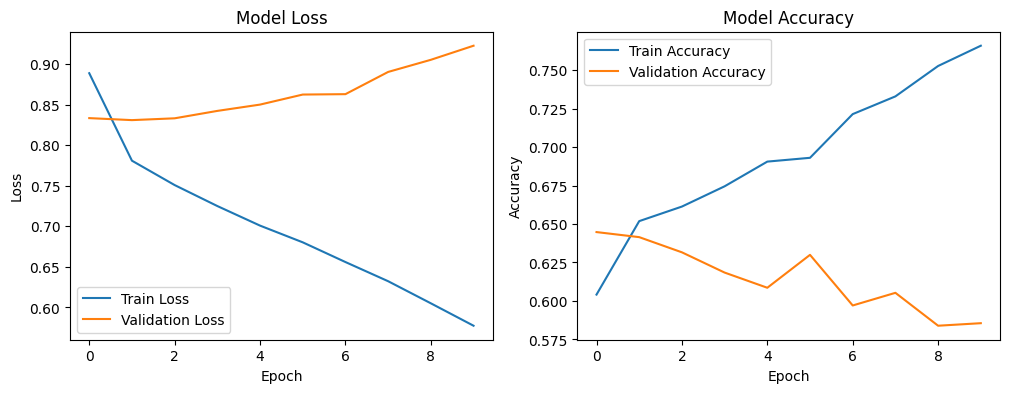

In [36]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(initial_history.history['loss'], label='Train Loss')
plt.plot(initial_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(initial_history.history['accuracy'], label='Train Accuracy')
plt.plot(initial_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [37]:
def create_network(input_dim, neurons_1layer, neurons_2layer, activation_function):
    model = keras.Sequential([
        layers.Dense(neurons_1layer, activation=activation_function, input_shape=(input_dim,)),
        layers.Dense(neurons_2layer, activation=activation_function),
        layers.Dropout(0.1),
        layers.Dense(3, activation="softmax")
    ])
    return model

In [43]:
GRID_SEARCH = {
    "learning_rate": [1e-3],
    "epochs": [5, 6, 7, 8, 9, 10],
    "neurons_1layer": [50, 55],
    "neurons_2layer": [30, 50],
    "activation_functions": ['relu', 'sigmoid', 'tanh'],
    "batch_size": [200]
}

In [39]:
grid_combinations = list(itertools.product(
    GRID_SEARCH['learning_rate'],
    GRID_SEARCH['epochs'],
    GRID_SEARCH['neurons_1layer'],
    GRID_SEARCH['neurons_2layer'],
    GRID_SEARCH['activation_functions'],
    GRID_SEARCH['batch_size']
))

In [40]:
best_params = None
best_val_loss = np.inf

In [41]:
for combination in grid_combinations:
    learning_rate, epochs, neurons_1layer, neurons_2layer, activation_function, batch_size = combination

    print(f"Testing combination: lr={learning_rate}, epochs={epochs}, neurons_1layer={neurons_1layer}, neurons_2layer={neurons_2layer}, activation={activation_function}, batch_size={batch_size}")

    # Create the model with current hyperparameters
    model = create_network(X_train.shape[1], neurons_1layer, neurons_2layer, activation_function)

    # Compile the model
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0
    )

    # Get the validation loss of the last epoch
    final_val_loss = history.history['val_loss'][-1]

    # Print the validation loss for the current combination
    print(f"Validation loss: {final_val_loss}")

    # Update the best parameters if current combination has the lowest validation loss
    if final_val_loss < best_val_loss:
        best_val_loss = final_val_loss
        best_params = {
            "learning_rate": learning_rate,
            "epochs": epochs,
            "neurons_1layer": neurons_1layer,
            "neurons_2layer": neurons_2layer,
            "activation_function": activation_function,
            "batch_size": batch_size
        }


Testing combination: lr=0.001, epochs=5, neurons_1layer=50, neurons_2layer=30, activation=relu, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8337848782539368
Testing combination: lr=0.001, epochs=5, neurons_1layer=50, neurons_2layer=30, activation=sigmoid, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.9551514983177185
Testing combination: lr=0.001, epochs=5, neurons_1layer=50, neurons_2layer=30, activation=tanh, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8428950905799866
Testing combination: lr=0.001, epochs=5, neurons_1layer=50, neurons_2layer=50, activation=relu, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8411045670509338
Testing combination: lr=0.001, epochs=5, neurons_1layer=50, neurons_2layer=50, activation=sigmoid, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.9984552264213562
Testing combination: lr=0.001, epochs=5, neurons_1layer=50, neurons_2layer=50, activation=tanh, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8304070830345154
Testing combination: lr=0.001, epochs=5, neurons_1layer=55, neurons_2layer=30, activation=relu, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8518264293670654
Testing combination: lr=0.001, epochs=5, neurons_1layer=55, neurons_2layer=30, activation=sigmoid, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.9900364875793457
Testing combination: lr=0.001, epochs=5, neurons_1layer=55, neurons_2layer=30, activation=tanh, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8404218554496765
Testing combination: lr=0.001, epochs=5, neurons_1layer=55, neurons_2layer=50, activation=relu, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8282440900802612
Testing combination: lr=0.001, epochs=5, neurons_1layer=55, neurons_2layer=50, activation=sigmoid, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.9483960866928101
Testing combination: lr=0.001, epochs=5, neurons_1layer=55, neurons_2layer=50, activation=tanh, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8374972343444824
Testing combination: lr=0.001, epochs=6, neurons_1layer=50, neurons_2layer=30, activation=relu, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8248191475868225
Testing combination: lr=0.001, epochs=6, neurons_1layer=50, neurons_2layer=30, activation=sigmoid, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.9505994915962219
Testing combination: lr=0.001, epochs=6, neurons_1layer=50, neurons_2layer=30, activation=tanh, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8490509390830994
Testing combination: lr=0.001, epochs=6, neurons_1layer=50, neurons_2layer=50, activation=relu, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8297429084777832
Testing combination: lr=0.001, epochs=6, neurons_1layer=50, neurons_2layer=50, activation=sigmoid, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.953628659248352
Testing combination: lr=0.001, epochs=6, neurons_1layer=50, neurons_2layer=50, activation=tanh, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.835632860660553
Testing combination: lr=0.001, epochs=6, neurons_1layer=55, neurons_2layer=30, activation=relu, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8312276005744934
Testing combination: lr=0.001, epochs=6, neurons_1layer=55, neurons_2layer=30, activation=sigmoid, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.9572227001190186
Testing combination: lr=0.001, epochs=6, neurons_1layer=55, neurons_2layer=30, activation=tanh, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8424732089042664
Testing combination: lr=0.001, epochs=6, neurons_1layer=55, neurons_2layer=50, activation=relu, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8282189965248108
Testing combination: lr=0.001, epochs=6, neurons_1layer=55, neurons_2layer=50, activation=sigmoid, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.9151854515075684
Testing combination: lr=0.001, epochs=6, neurons_1layer=55, neurons_2layer=50, activation=tanh, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8458006978034973
Testing combination: lr=0.001, epochs=7, neurons_1layer=50, neurons_2layer=30, activation=relu, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8474054932594299
Testing combination: lr=0.001, epochs=7, neurons_1layer=50, neurons_2layer=30, activation=sigmoid, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.9429683685302734
Testing combination: lr=0.001, epochs=7, neurons_1layer=50, neurons_2layer=30, activation=tanh, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.842211902141571
Testing combination: lr=0.001, epochs=7, neurons_1layer=50, neurons_2layer=50, activation=relu, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.842119038105011
Testing combination: lr=0.001, epochs=7, neurons_1layer=50, neurons_2layer=50, activation=sigmoid, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.9621667265892029
Testing combination: lr=0.001, epochs=7, neurons_1layer=50, neurons_2layer=50, activation=tanh, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.833512008190155
Testing combination: lr=0.001, epochs=7, neurons_1layer=55, neurons_2layer=30, activation=relu, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8469997048377991
Testing combination: lr=0.001, epochs=7, neurons_1layer=55, neurons_2layer=30, activation=sigmoid, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.9251294136047363
Testing combination: lr=0.001, epochs=7, neurons_1layer=55, neurons_2layer=30, activation=tanh, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8467611074447632
Testing combination: lr=0.001, epochs=7, neurons_1layer=55, neurons_2layer=50, activation=relu, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8397822380065918
Testing combination: lr=0.001, epochs=7, neurons_1layer=55, neurons_2layer=50, activation=sigmoid, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.916031002998352
Testing combination: lr=0.001, epochs=7, neurons_1layer=55, neurons_2layer=50, activation=tanh, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8439106345176697
Testing combination: lr=0.001, epochs=8, neurons_1layer=50, neurons_2layer=30, activation=relu, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8384836912155151
Testing combination: lr=0.001, epochs=8, neurons_1layer=50, neurons_2layer=30, activation=sigmoid, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8944752216339111
Testing combination: lr=0.001, epochs=8, neurons_1layer=50, neurons_2layer=30, activation=tanh, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8335811495780945
Testing combination: lr=0.001, epochs=8, neurons_1layer=50, neurons_2layer=50, activation=relu, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8130485415458679
Testing combination: lr=0.001, epochs=8, neurons_1layer=50, neurons_2layer=50, activation=sigmoid, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.9069920778274536
Testing combination: lr=0.001, epochs=8, neurons_1layer=50, neurons_2layer=50, activation=tanh, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8502737283706665
Testing combination: lr=0.001, epochs=8, neurons_1layer=55, neurons_2layer=30, activation=relu, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8310148119926453
Testing combination: lr=0.001, epochs=8, neurons_1layer=55, neurons_2layer=30, activation=sigmoid, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8892384767532349
Testing combination: lr=0.001, epochs=8, neurons_1layer=55, neurons_2layer=30, activation=tanh, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8477088809013367
Testing combination: lr=0.001, epochs=8, neurons_1layer=55, neurons_2layer=50, activation=relu, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8528978228569031
Testing combination: lr=0.001, epochs=8, neurons_1layer=55, neurons_2layer=50, activation=sigmoid, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.901218831539154
Testing combination: lr=0.001, epochs=8, neurons_1layer=55, neurons_2layer=50, activation=tanh, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8409733176231384
Testing combination: lr=0.001, epochs=9, neurons_1layer=50, neurons_2layer=30, activation=relu, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8465364575386047
Testing combination: lr=0.001, epochs=9, neurons_1layer=50, neurons_2layer=30, activation=sigmoid, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.9255669116973877
Testing combination: lr=0.001, epochs=9, neurons_1layer=50, neurons_2layer=30, activation=tanh, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8510934710502625
Testing combination: lr=0.001, epochs=9, neurons_1layer=50, neurons_2layer=50, activation=relu, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.835813581943512
Testing combination: lr=0.001, epochs=9, neurons_1layer=50, neurons_2layer=50, activation=sigmoid, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8801295757293701
Testing combination: lr=0.001, epochs=9, neurons_1layer=50, neurons_2layer=50, activation=tanh, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8549326658248901
Testing combination: lr=0.001, epochs=9, neurons_1layer=55, neurons_2layer=30, activation=relu, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8371187448501587
Testing combination: lr=0.001, epochs=9, neurons_1layer=55, neurons_2layer=30, activation=sigmoid, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8959164619445801
Testing combination: lr=0.001, epochs=9, neurons_1layer=55, neurons_2layer=30, activation=tanh, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8565875887870789
Testing combination: lr=0.001, epochs=9, neurons_1layer=55, neurons_2layer=50, activation=relu, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8441162109375
Testing combination: lr=0.001, epochs=9, neurons_1layer=55, neurons_2layer=50, activation=sigmoid, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8767359852790833
Testing combination: lr=0.001, epochs=9, neurons_1layer=55, neurons_2layer=50, activation=tanh, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8516499400138855
Testing combination: lr=0.001, epochs=10, neurons_1layer=50, neurons_2layer=30, activation=relu, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8496648073196411
Testing combination: lr=0.001, epochs=10, neurons_1layer=50, neurons_2layer=30, activation=sigmoid, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.9076746106147766
Testing combination: lr=0.001, epochs=10, neurons_1layer=50, neurons_2layer=30, activation=tanh, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8535151481628418
Testing combination: lr=0.001, epochs=10, neurons_1layer=50, neurons_2layer=50, activation=relu, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8443887829780579
Testing combination: lr=0.001, epochs=10, neurons_1layer=50, neurons_2layer=50, activation=sigmoid, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8659353852272034
Testing combination: lr=0.001, epochs=10, neurons_1layer=50, neurons_2layer=50, activation=tanh, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8432610034942627
Testing combination: lr=0.001, epochs=10, neurons_1layer=55, neurons_2layer=30, activation=relu, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8456822633743286
Testing combination: lr=0.001, epochs=10, neurons_1layer=55, neurons_2layer=30, activation=sigmoid, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8864662051200867
Testing combination: lr=0.001, epochs=10, neurons_1layer=55, neurons_2layer=30, activation=tanh, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8512231707572937
Testing combination: lr=0.001, epochs=10, neurons_1layer=55, neurons_2layer=50, activation=relu, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8541391491889954
Testing combination: lr=0.001, epochs=10, neurons_1layer=55, neurons_2layer=50, activation=sigmoid, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8916327953338623
Testing combination: lr=0.001, epochs=10, neurons_1layer=55, neurons_2layer=50, activation=tanh, batch_size=200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation loss: 0.8522558808326721


In [42]:
print("Best hyperparameters found:")
print(best_params)
print(f"Best validation loss: {best_val_loss}")

Best hyperparameters found:
{'learning_rate': 0.001, 'epochs': 8, 'neurons_1layer': 50, 'neurons_2layer': 50, 'activation_function': 'relu', 'batch_size': 200}
Best validation loss: 0.8130485415458679


In [44]:
best_params = {'learning_rate': 0.001, 'epochs': 8, 'neurons_1layer': 50, 'neurons_2layer': 50, 'activation_function': 'relu', 'batch_size': 200}

In [45]:
best_model = create_network(
    X_train.shape[1],
    best_params["neurons_1layer"],
    best_params["neurons_2layer"],
    best_params["activation_function"]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [46]:
best_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params["learning_rate"]),
    metrics=['accuracy']
)

In [47]:
best_history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=best_params["epochs"],
    batch_size=best_params["batch_size"],
    verbose=1  # Show progress for the final training
)

Epoch 1/8
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4437 - loss: 1.0512 - val_accuracy: 0.5905 - val_loss: 0.9685
Epoch 2/8
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6025 - loss: 0.9405 - val_accuracy: 0.5954 - val_loss: 0.9097
Epoch 3/8
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6021 - loss: 0.8911 - val_accuracy: 0.6053 - val_loss: 0.8799
Epoch 4/8
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6202 - loss: 0.8429 - val_accuracy: 0.6102 - val_loss: 0.8610
Epoch 5/8
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6287 - loss: 0.8180 - val_accuracy: 0.6151 - val_loss: 0.8527
Epoch 6/8
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6412 - loss: 0.7892 - val_accuracy: 0.6201 - val_loss: 0.8461
Epoch 7/8
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6533 - loss: 0.7841 - val_accuracy: 0.6349 - val_loss: 0.8462
Epoch 8/8
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6752 - loss: 0.7272 - val_accuracy: 0.6234 - val_loss: 0

In [51]:
final_val_loss = best_history.history['val_loss'][-1]
final_val_accuracy = best_history.history['val_accuracy'][-1]

print(f"Final validation loss with best hyperparameters: {final_val_loss}")
print(f"Final validation accuracy with best hyperparameters: {final_val_accuracy}")

Final validation loss with best hyperparameters: 0.8455597758293152
Final validation accuracy with best hyperparameters: 0.6233552694320679


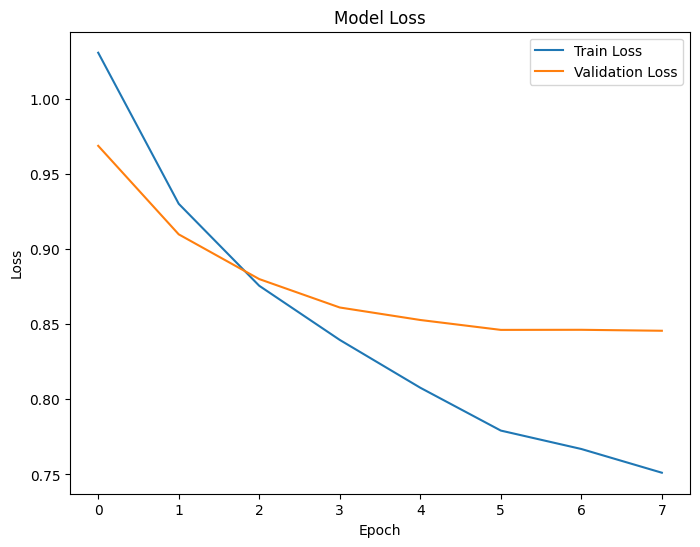

In [52]:
plt.figure(figsize=(8, 6))
plt.plot(best_history.history['loss'], label='Train Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [53]:
best_model.save("best_model.h5")